In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [2]:
train = pd.read_csv("train.csv")
print(train.shape)

(42000, 785)


In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv("test.csv")
print(test.shape)

(28000, 784)


In [5]:
y_train = train["label"] #what number every pixeled row creates
X_train = train.drop(labels=["label"],axis=1) #dataframe without the 'answer'

/Users/drew/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


 	 # y_train value counts # 
 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


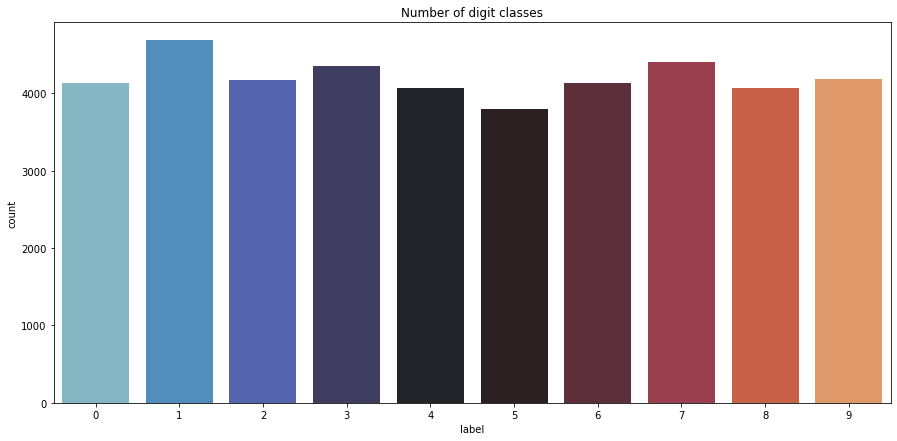

In [6]:
plt.figure(figsize=(15,7))
g = sns.countplot(y_train, palette="icefire")
plt.title("Number of digit classes")
print(" \t # y_train value counts # \n",y_train.value_counts())
#prints histogram of what the frequency of the digits in the train dataframe

In [7]:
X_train = X_train / 255.0
X_test = test / 255.0
#pixel values can be from 0-255
#Channel is a conventional term used to refer to a certain component of an image. 
#An image from a standard digital camera will have three channels – red, green and blue – you 
#can imagine those as three 2d-matrices stacked over each other (one for each color), each 
#having pixel values in the range 0 to 255.

#The images are not grayscaled (0 as black and 255 as white)^

In [8]:
X_test = X_test.values.reshape(-1,28,28,1)
X_train = X_train.values.reshape(-1,28,28,1)
#(-1 = infer, width, height, number of channels)

In [9]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(y_train, num_classes = 10) #returns binary result of input with specified number of classes for the outputs

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)
#randomize and split

x_train shape (37800, 28, 28, 1)
x_val shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_val shape (4200, 10)


In [11]:
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
import time
from datetime import datetime

#NAME = "16by-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = Sequential() #feedforward

model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
#convolution operation with specified number of filters(depth), filter size. The more filters, the better.
model.add(MaxPool2D(pool_size=(2,2))) #reduces spacial size of feature map. MaxPool2d takes max value of each feature map
model.add(Dropout(0.25)) #prevents overfitting

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten()) #takes the 2d final pooling output to 1d
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax")) #converts a vector of values to a probability distribution

In [12]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [13]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
epochs = 3
batch_size = 250

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=5,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(X_train)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=6)

In [ ]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[tensorboard_callback])

/Users/drew/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
151/151 [==============================] - 52s 181ms/step - loss: 1.5933 - accuracy: 0.4570 - val_loss: 0.2288 - val_accuracy: 0.9405
Epoch 2/3
151/151 [==============================] - 26s 175ms/step - loss: 0.4843 - accuracy: 0.8448 - val_loss: 0.1297 - val_accuracy: 0.9645
Epoch 3/3
118/151 [======================>.......] - ETA: 5s - loss: 0.3254 - accuracy: 0.8986

In [ ]:
%tensorboard --logdir logs

In [ ]:
print("Accuracy of the model is --> " , model.evaluate(X_val, Y_val, batch_size=batch_size)[1]*100 , "%")
print("Loss of the model is --> " , model.evaluate(X_val, Y_val, batch_size=batch_size)[0])

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(X_train[0], interpolation='nearest')
plt.show()

In [ ]:
model.save('digitreader')

In [ ]:
new_model = tf.keras.models.load_model('digitreader')

In [ ]:
predictions = new_model.predict(X_train)

In [ ]:
print(np.argmax(predictions[0]))

In [51]:
#helpful links:
#https://www.kaggle.com/abhaporwal/mnist-digit-cnn/comments
#https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/
#https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/